<a href="https://colab.research.google.com/github/deepkick/kagglebook/blob/master/ch01/PredictFutureSales_A_beginner_guide_for_sale_data_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A beginner guide for sale data prediction
https://www.kaggle.com/minhtriet/a-beginner-guide-for-sale-data-prediction  

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')
items = pd.read_csv('../input/items.csv')
item_cats = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')

In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59.0,22154.0,999.00,1.0
1,03.01.2013,0,25.0,2552.0,899.00,1.0
2,05.01.2013,0,25.0,2552.0,899.00,-1.0
3,06.01.2013,0,25.0,2554.0,1709.05,1.0
4,15.01.2013,0,25.0,2555.0,1099.00,1.0
...,...,...,...,...,...,...
2736372,21.07.2015,30,42.0,16167.0,799.00,1.0
2736373,24.07.2015,30,42.0,16167.0,799.00,1.0
2736374,12.07.2015,30,42.0,16169.0,299.00,1.0
2736375,09.07.2015,30,42.0,16170.0,1999.00,1.0


In [12]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [13]:

test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]


In [14]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

In [15]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59.0,22154.0,999.0,1.0
10,03.01.2013,0,25.0,2574.0,399.0,2.0
11,05.01.2013,0,25.0,2574.0,399.0,1.0
12,07.01.2013,0,25.0,2574.0,399.0,1.0
13,08.01.2013,0,25.0,2574.0,399.0,2.0
...,...,...,...,...,...,...
2736371,20.07.2015,30,42.0,16156.0,1299.0,-1.0
2736372,21.07.2015,30,42.0,16167.0,799.0,1.0
2736373,24.07.2015,30,42.0,16167.0,799.0,1.0
2736374,12.07.2015,30,42.0,16169.0,299.0,1.0


In [16]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


## Data Exploration

Next, we would like to gain some insights about the data. I will attack from two angles, shop and item categories.

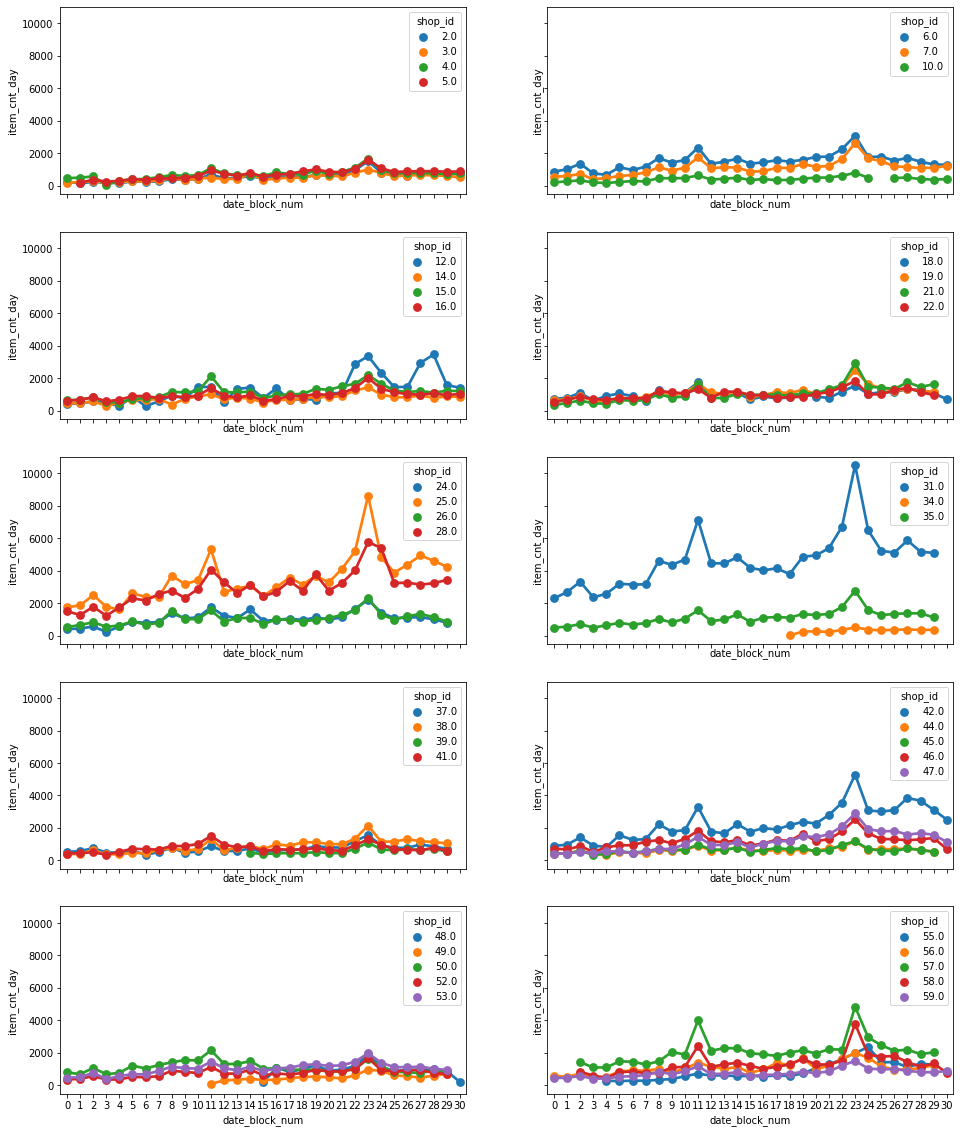

In [17]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1